# Facebook Unsupervised Analysis Project

## Q1: Introduction

In the dynamic world of social media, understanding user engagement on platforms like Facebook is crucial for businesses and content creators alike. Engagement metrics such as likes, comments, shares, and reactions serve as key indicators of how well content resonates with audiences. Facebook, with its diverse content formats including photos, videos, and text posts, offers unique insights into how different types of content perform. Among these, photos have consistently shown to command the highest engagement rates, making them a central focus for those looking to maximize visibility and interaction on their pages, however the dataset provided could prove the other way around.

Based on the dataset provided, the average number of comments per post is approximately 234, but the distribution is highly skewed with a standard deviation of 856. Also, posts are shared about 40 times on average. Similar to comments, the distribution is skewed (std: 124) with most posts receiving fewer shares (median: 0). Regarding likes,  posts receive an average of 221 likes. The distribution is also skewed (std: 467), with a median of 57 likes. Last but not least, loves, wows, hahas, sads and angrys are less common than likes, comments, and shares. For example, the average number of loves is 13, wows are about 1, hahas are less than 1 on average, and sads and angrys are even less common.

In [1]:
########################################
# importing packages
########################################
import numpy             as np                   # mathematical essentials
import pandas            as pd                   # data science essentials
import matplotlib.pyplot as plt                  # fundamental data visualization
import seaborn           as sns                  # enhanced visualization

# packages for unsupervised learning
from sklearn.preprocessing   import StandardScaler      # standard scaler
from sklearn.decomposition   import PCA                 # pca
from scipy.cluster.hierarchy import dendrogram, linkage # dendrograms
from sklearn.cluster         import KMeans              # k-means clustering
from itertools import cycle

########################################
# loading data and setting display options
########################################
# loading data
fb_path = 'C:\\Users\\ihida\\Documents\\HULT\\Intro to Machine Learning\\facebook_live_data.xlsx'

fb_df = pd.read_excel(io = fb_path,
                      header = 0,
                      index_col = 'status_id')


# setting print options
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', 100)

In [2]:
########################################
# unsupervised_scaler
########################################
def scaler(df):
    """
    Standardizes a dataset (mean = 0, variance = 1). Returns a new DataFrame.
    Requires sklearn.preprocessing.StandardScaler()
    
    PARAMETERS
    ----------
    df     | DataFrame to be used for scaling
    """

    # INSTANTIATING a StandardScaler() object
    scaler = StandardScaler(copy = True)


    # FITTING the scaler with the data
    scaler.fit(df)


    # TRANSFORMING our data after fit
    x_scaled = scaler.transform(df)

    
    # converting scaled data into a DataFrame
    new_df = pd.DataFrame(x_scaled)


    # reattaching column names
    new_df.columns = list(df.columns)
    
    return new_df

In [3]:
# defining a mapping dictionary to transform column status_type
status_mapping = {'photo': 1, 'text': 2, 'video': 3}

# applying the mapping to the 'status_type' column
fb_df['status_type'] = fb_df['status_type'].map(status_mapping)

In [4]:
# checking information about each column
fb_df.info(verbose = True)

<class 'pandas.core.frame.DataFrame'>
Index: 2362 entries, 1 to 2362
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   status_type     2362 non-null   int64         
 1   time_published  2362 non-null   datetime64[ns]
 2   num_comments    2362 non-null   int64         
 3   num_shares      2362 non-null   int64         
 4   num_likes       2362 non-null   int64         
 5   num_loves       2362 non-null   int64         
 6   num_wows        2362 non-null   int64         
 7   num_hahas       2362 non-null   int64         
 8   num_sads        2362 non-null   int64         
 9   num_angrys      2362 non-null   int64         
dtypes: datetime64[ns](1), int64(9)
memory usage: 203.0 KB


In [5]:
# descriptive statistics about each numeric column
fb_df.describe(include = 'number').round(decimals = 2)

,status_type,num_comments,num_shares,num_likes,num_loves,num_wows,num_hahas,num_sads,num_angrys
count,2362.00,2362.00,2362.00,2362.00,2362.00,2362.00,2362.00,2362.00,2362.00
mean,1.71,233.73,39.82,221.15,12.83,1.28,0.74,0.26,0.12
std,0.92,856.36,123.78,467.31,41.00,8.72,4.11,1.84,0.90
min,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,1.00,0.00,0.00,17.00,0.00,0.00,0.00,0.00,0.00
50%,1.00,4.00,0.00,57.00,0.00,0.00,0.00,0.00,0.00
75%,3.00,23.00,3.00,186.00,3.00,0.00,0.00,0.00,0.00
max,3.00,10960.00,1260.00,4315.00,421.00,278.00,102.00,46.00,31.00


In [6]:
# value counts for status type
print(f"""\
{fb_df['status_type'].value_counts(normalize=False).to_string(buf=None)}""")

status_type
1    1443
3     763
2     156


## Q2:

From this preliminary analysis, we can see that while photos are the most 'liked' content type, they do not lead in terms of total engagement when all types of interactions are considered. Videos are the most engaging overall, particularly excelling in 'loves', 'comments', and 'shares', suggesting they might be more effective for a deeper and broader engagement strategy. Here is the breakdown of the different kind of posts versus the reactions associated.

* Likes: Photos lead significantly with a total of 253,180 likes, which is far more than the likes for videos (196,253) and text (72,918).

* Loves: Photos also perform well with regards to 'loves', having 2,009 in total. However, they are outperformed by videos, which have a considerably higher total of 28,100 'loves'.

* Wows: Photos have a lower 'wow' count (983) compared to videos (1,912) but more than text posts (134).

* Hahas: The number of 'haha' reactions is the least for photos at 168, with videos leading at 1,560 and text posts having only 20.

* Sads: Photos have a total of 239 'sad' reactions, which is less than videos (336) but more than text posts (40).

* Angrys: Photos have the least amount of 'angry' reactions with 78, whereas videos have a much higher count at 210, and text posts have the fewest with only 2.

* Comments: Photos are less engaging in terms of prompting comments with a total of 31,796, compared to a much higher interaction on videos, which have 514,376 comments.

* Shares: Photos are shared 4,385 times, which is less than videos (89,158 shares) but more than text posts (517 shares).

* Total Engagement: The overall engagement for photos sums up to 292,838, which is significantly less than videos (831,905) but higher than text posts (79,718).

In [7]:
# removing column time_published
fb_df = fb_df.drop(columns=['time_published'], axis = 1)

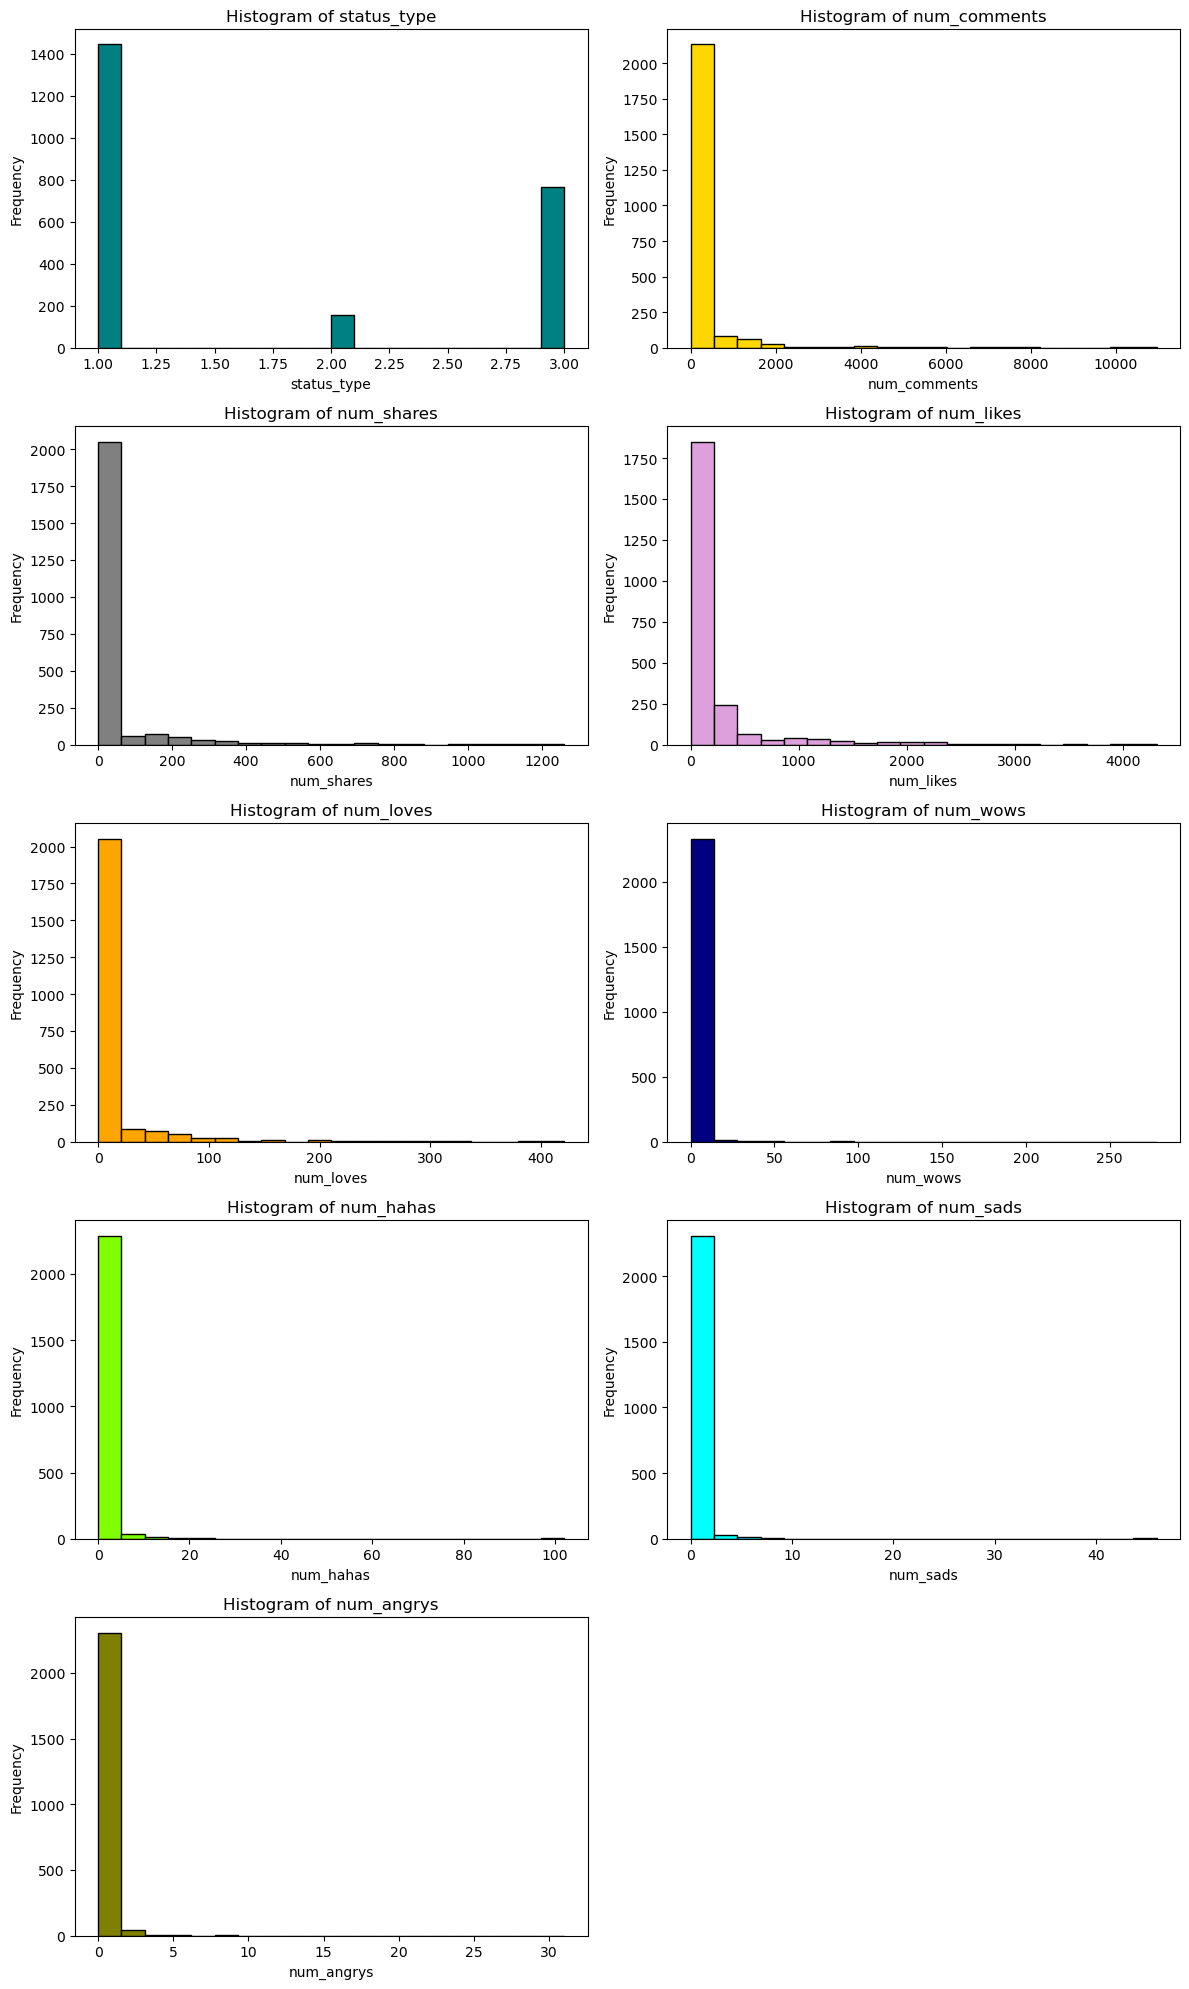

In [8]:
# defining a list of colors for the plots
colors = ['teal', 'gold', 'gray', 'plum', 'orange', 'navy', 'chartreuse', 'cyan', 'olive']

# creating a cycle object to cycle through colors
color_cycle = cycle(colors)

# determining the number of rows and columns for the subplots
num_columns = len(fb_df.columns)
# arranging plots in 2 columns
num_rows = int(np.ceil(num_columns / 2))  

# creating a figure and set of subplots
fig, axes = plt.subplots(num_rows, 2, figsize=(12, num_rows * 4))  #adjust size as needed
axes = axes.flatten()  #flatten the axes array for easier iteration

# plotting histograms for each column in the DataFrame
for i, column in enumerate(fb_df.columns):
    color = next(color_cycle)  # get the next color from the cycle
    fb_df[column].hist(bins=20, color=color, edgecolor='black', ax=axes[i])
    axes[i].set_title(f'Histogram of {column}')
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Frequency')
    axes[i].grid(False)  # disable grid to reduce visual clutter
    
# disabling unused axes if the number of plots is less than the number of subplots
if num_columns % 2 != 0:
    axes[-1].axis('off')  # Turn off the last subplot if unused

# adjusting layout and display the plot
plt.tight_layout()
plt.show()

In [9]:
# removing status type column
facebook_df = fb_df.drop(['status_type'], axis = 1)

# scaling (normalizing) variables before correlation analysis
facebook_scaled = scaler(df = facebook_df)

# checking pre- and post-scaling variance
print(np.var(fb_df), '\n\n')
print(np.var(facebook_scaled))

status_type          0.851073
num_comments    733040.526533
num_shares       15315.110634
num_likes       218288.813477
num_loves         1680.086166
num_wows            75.978259
num_hahas           16.896863
num_sads             3.392409
num_angrys           0.817271
dtype: float64 


num_comments    1.0
num_shares      1.0
num_likes       1.0
num_loves       1.0
num_wows        1.0
num_hahas       1.0
num_sads        1.0
num_angrys      1.0
dtype: float64


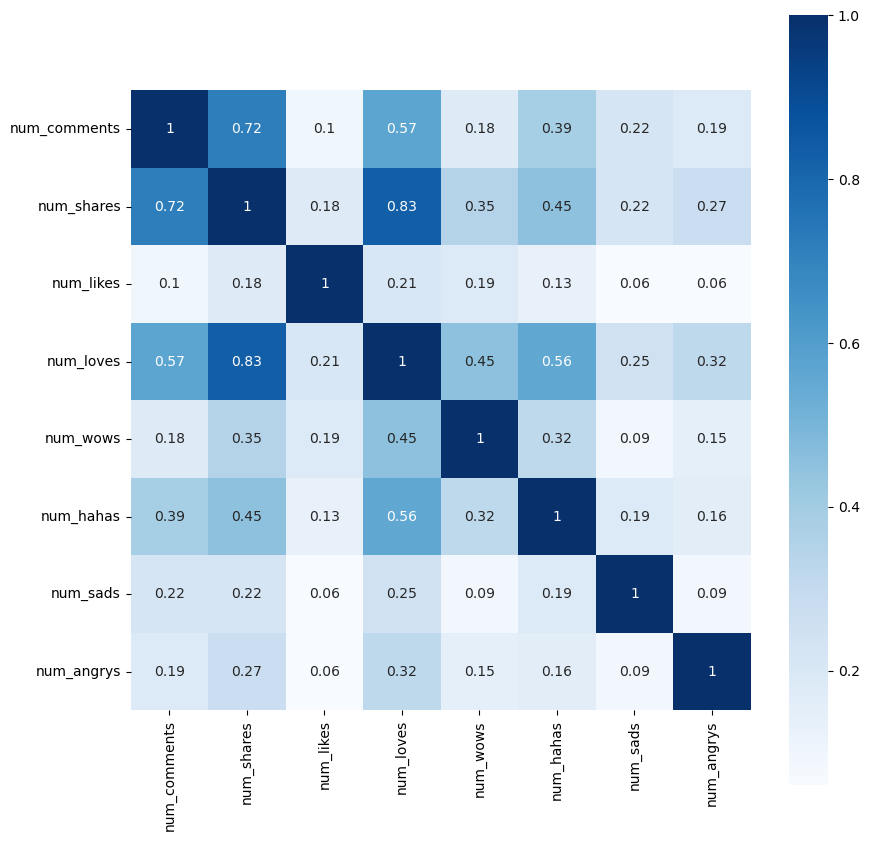

In [10]:
# setting plot size
fig, ax = plt.subplots(figsize = (10, 10))

# developing a correlation matrix object
df_corr = facebook_scaled.corr(method = 'pearson').round(decimals = 2)

# creating a correlation heatmap
sns.heatmap(data   = df_corr,
            cmap   = 'Blues',
            square = True,
            annot  = True)

# rendering the heatmap
plt.show()

In [11]:
# instantiating a PCA object with no limit to principal components
pca = PCA(n_components = None,
          random_state = 702)

# fitting and transforming the scaled data
facebook_pca = pca.fit_transform(facebook_scaled)

# comparing dimensions of each DataFrame
print("Original shape:", facebook_scaled.shape)
print("PCA shape     :", facebook_pca.shape)

Original shape: (2362, 8)
PCA shape     : (2362, 8)


In [12]:
# component number counter
component_number = 0

# looping over each principal component
for variance in pca.explained_variance_ratio_:
    component_number += 1
    print(f"PC {component_number}: {variance.round(3)}")

PC 1: 0.409
PC 2: 0.128
PC 3: 0.115
PC 4: 0.11
PC 5: 0.1
PC 6: 0.077
PC 7: 0.045
PC 8: 0.017


In [13]:
# printing the sum of all explained variance ratios
print(pca.explained_variance_ratio_.sum(axis = 0))

1.0


## Q3:

I chose PCA 3 as the cutoff point because it represents around 65.2% of the variance in all the data. This is the "elbow" point where the eigenvalues start to level off. Components before this point explain most of the variance in the data, while those after contribute less significantly. The vertical green dotted line in the Scree Plot below illustrates that more clearly.

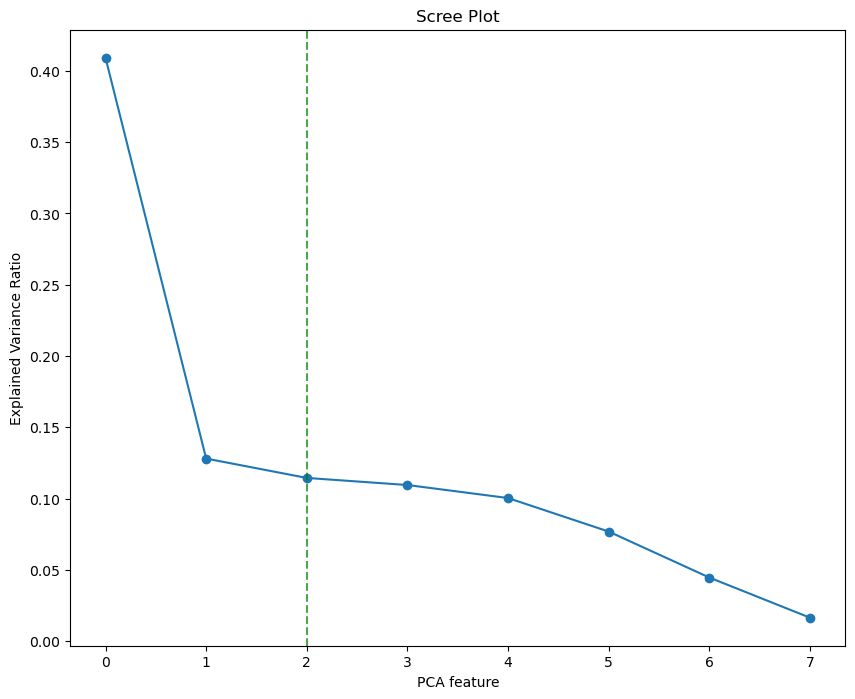

In [14]:
# data preparation for the scree plot
explained_variance = pca.explained_variance_ratio_
components_explained_df = pd.DataFrame({
    'Principal Component': range(0, len(explained_variance)),
    'Explained Variance': explained_variance
})

# plotting
plt.figure(figsize=(10, 8))
plt.plot(components_explained_df['Principal Component'], components_explained_df['Explained Variance'], marker='o', label='Individual Explained Variance')
plt.axvline(x=2, color='g', linestyle='--', alpha=0.7, label='Component 3')  # Vertical line at PCA 3
plt.xlabel('PCA feature')
plt.ylabel('Explained Variance Ratio')
plt.title('Scree Plot')
plt.xticks(components_explained_df['Principal Component'])  # Ensure all component numbers are shown
plt.grid(False)
plt.show()

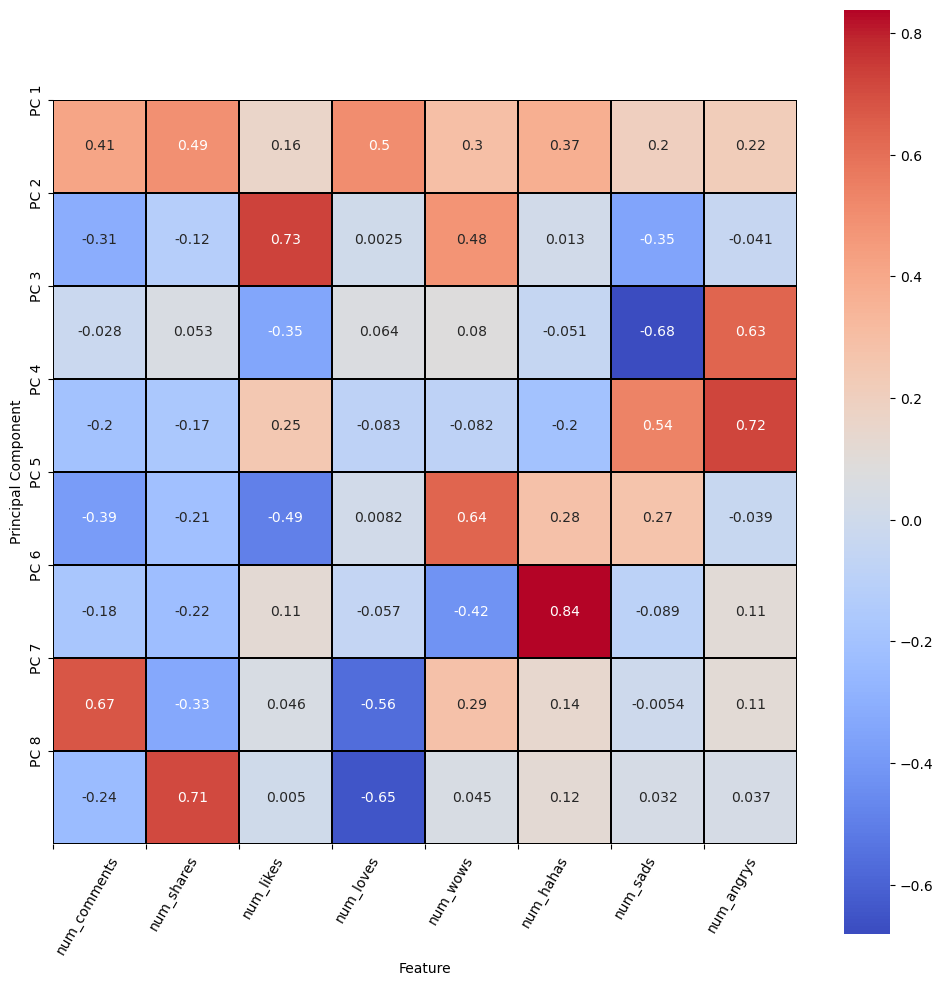

In [15]:
# setting plot size
fig, ax = plt.subplots(figsize = (12, 12))

# developing a PC to feature heatmap
sns.heatmap(pca.components_, 
            cmap = 'coolwarm',
            square = True,
            annot = True,
            linewidths = 0.1,
            linecolor = 'black')

# setting more plot options
plt.yticks([0, 1, 2, 3, 4, 5, 6, 7],
           ["PC 1", "PC 2", "PC 3", "PC 4", "PC 5", "PC 6", "PC 7", "PC 8"])

plt.xticks(range(0, 8),
           facebook_scaled.columns,
           rotation=60,
           ha='left')

plt.xlabel(xlabel = "Feature")
plt.ylabel(ylabel = "Principal Component")

# displaying the plot
plt.show()

In [16]:
# analyzing PC factor loadings

# transposing pca components
factor_loadings_df = pd.DataFrame(np.transpose(pca.components_.round(decimals = 2)))

# naming rows as original features
factor_loadings_df = factor_loadings_df.set_index(facebook_scaled.columns)

# checking the result
print(factor_loadings_df)

                 0     1     2     3     4     5     6     7
num_comments  0.41 -0.31 -0.03 -0.20 -0.39 -0.18  0.67 -0.24
num_shares    0.49 -0.12  0.05 -0.17 -0.21 -0.22 -0.33  0.71
num_likes     0.16  0.73 -0.35  0.25 -0.49  0.11  0.05  0.00
num_loves     0.50  0.00  0.06 -0.08  0.01 -0.06 -0.56 -0.65
num_wows      0.30  0.48  0.08 -0.08  0.64 -0.42  0.29  0.04
num_hahas     0.37  0.01 -0.05 -0.20  0.28  0.84  0.14  0.12
num_sads      0.20 -0.35 -0.68  0.54  0.27 -0.09 -0.01  0.03
num_angrys    0.22 -0.04  0.63  0.72 -0.04  0.11  0.11  0.04


In [17]:
# naming each principal component
factor_loadings_df.columns = ['Social Spark',          # + loves, + shares, + comments
                              'Emotion Catalyst',      # + likes, + wows, - sads
                              'Controversial Charmer', # - sads, + angrys, - likes
                              '3',                     # after elbow
                              '4',                     # after elbow
                              '5',                     # after elbow  
                              '6',                     # after elbow
                              '7']                     # after elbow


# checking the result
factor_loadings_df

,Social Spark,Emotion Catalyst,Controversial Charmer,3,4,5,6,7
num_comments,0.41,-0.31,-0.03,-0.20,-0.39,-0.18,0.67,-0.24
num_shares,0.49,-0.12,0.05,-0.17,-0.21,-0.22,-0.33,0.71
num_likes,0.16,0.73,-0.35,0.25,-0.49,0.11,0.05,0.00
num_loves,0.50,0.00,0.06,-0.08,0.01,-0.06,-0.56,-0.65
num_wows,0.30,0.48,0.08,-0.08,0.64,-0.42,0.29,0.04
num_hahas,0.37,0.01,-0.05,-0.20,0.28,0.84,0.14,0.12
num_sads,0.20,-0.35,-0.68,0.54,0.27,-0.09,-0.01,0.03
num_angrys,0.22,-0.04,0.63,0.72,-0.04,0.11,0.11,0.04


## Q3:

A brief analysis of the principal components retained:

Social Spark (PC1):

This component has strong positive associations with num_comments (0.41), num_shares (0.49), and num_loves (0.50).
It seems to represent the engagement aspect of the content that sparks conversation, is widely shared, and is loved by the audience.
Posts that would score high on this component might include compelling stories, relatable experiences, or high-quality content that resonates with people, prompting them to express their appreciation through comments, shares, and 'love' reactions.
An example could be a heartwarming video of a community coming together to help someone in need, which would likely encourage viewers to comment, express their love, and share the post with others.

Emotion Catalyst (PC2):

Dominated by a strong positive loading on num_likes (0.73) and a moderate negative loading on num_sads (-0.35).
This component captures posts that are generally well-received with 'likes' but do not tend to make people feel sad.
These could be entertaining or happy content that is generally likable but not emotionally deep enough to elicit sadness.
For instance, a funny animal video or an impressive display of talent could get many likes for being enjoyable without necessarily causing any sadness.

Controversial Charmer (PC3):

Characterized by high loadings on num_wows (-0.68) and num_angrys (0.63), this component suggests content that surprises and might provoke disagreement or controversy.
Such posts may feature unexpected news, polarizing topics, or provocative statements that make people react with surprise or anger.
An example might be a post revealing a sudden twist in a popular television show, or a post about a contentious political issue that splits opinion, leading to 'wow' reactions from the surprise element and 'angry' reactions from those who disagree or are upset by the content.

These insights suggest that the labeled components represent distinct types of engagement that are valuable for content creators or marketers to understand:

* Social Spark is about creating a sense of community and shared sentiment.
* Emotion Catalyst is about producing content that is universally appealing and positive.
* Controversial Charmer is about sparking debate and strong emotional reactions.

In [18]:
# converting into a DataFrame 
facebook_pca = pd.DataFrame(facebook_pca)

# renaming columns
facebook_pca.columns = factor_loadings_df.columns

# checking results
facebook_pca

,Social Spark,Emotion Catalyst,Controversial Charmer,3,4,5,6,7
0,-0.619670,-0.006476,0.031211,-0.028140,0.069438,0.030553,0.011254,-0.000399
1,-0.469623,0.126667,0.013848,-0.028868,0.082735,-0.020934,-0.053784,-0.088186
2,-0.469004,0.125796,0.015559,-0.028346,0.089355,-0.017813,-0.058132,-0.121798
3,0.367677,0.240069,-0.089732,-0.314233,0.234662,0.932251,-0.089207,-0.068756
4,-0.019679,-0.278149,-0.276109,0.109002,0.151739,-0.213950,-0.170986,-0.007108
...,...,...,...,...,...,...,...,...
2357,-0.430884,0.084652,-0.004706,-0.030780,-0.039773,0.007068,-0.111433,-0.051283
2358,-0.667096,-0.222189,0.133994,-0.100760,0.215334,-0.003407,-0.002229,-0.001872
2359,-0.668470,-0.228442,0.136973,-0.102865,0.219563,-0.004391,-0.002620,-0.001914
2360,-0.669158,-0.231568,0.138463,-0.103917,0.221677,-0.004884,-0.002815,-0.001936


In [19]:
# exploring users in the Social Spark persona
len(facebook_pca['Social Spark'][facebook_pca['Social Spark'] > 1.0])

269

In [20]:
# exploring users in the Emotion Catalyst persona
len(facebook_pca['Emotion Catalyst'][facebook_pca['Emotion Catalyst'] > 1.0])

179

In [21]:
# exploring users in the Controversial Charmer persona
len(facebook_pca['Controversial Charmer'][facebook_pca['Controversial Charmer'] > 1.0])

43

In [22]:
# reducing to relevant Principal Components

# instantiating a new model using the first three principal components
pca_3 = PCA(n_components = 3,
            random_state = 702)

# fitting and transforming the facebook_scaled
facebook_pca_3 = pca_3.fit_transform(facebook_scaled)

####################
### Max PC Model ###
####################
# transposing pca components (pc = MAX)
factor_loadings = pd.DataFrame(np.transpose(pca.components_))

# naming rows as original features
factor_loadings = factor_loadings.set_index(facebook_scaled.columns)

##################
### 3 PC Model ###
##################
# transposing pca components (pc = 3)
factor_loadings_3 = pd.DataFrame(np.transpose(pca_3.components_))

# naming rows as original features
factor_loadings_3 = factor_loadings_3.set_index(facebook_scaled.columns)

# checking the results
print(f"""
MAX Components Factor Loadings
------------------------------
{factor_loadings.round(decimals = 2)}


3 Components Factor Loadings
------------------------------
{factor_loadings_3.round(decimals = 2)}
""")


MAX Components Factor Loadings
------------------------------
                 0     1     2     3     4     5     6     7
num_comments  0.41 -0.31 -0.03 -0.20 -0.39 -0.18  0.67 -0.24
num_shares    0.49 -0.12  0.05 -0.17 -0.21 -0.22 -0.33  0.71
num_likes     0.16  0.73 -0.35  0.25 -0.49  0.11  0.05  0.00
num_loves     0.50  0.00  0.06 -0.08  0.01 -0.06 -0.56 -0.65
num_wows      0.30  0.48  0.08 -0.08  0.64 -0.42  0.29  0.04
num_hahas     0.37  0.01 -0.05 -0.20  0.28  0.84  0.14  0.12
num_sads      0.20 -0.35 -0.68  0.54  0.27 -0.09 -0.01  0.03
num_angrys    0.22 -0.04  0.63  0.72 -0.04  0.11  0.11  0.04


3 Components Factor Loadings
------------------------------
                 0     1     2
num_comments  0.41 -0.31 -0.03
num_shares    0.49 -0.12  0.05
num_likes     0.16  0.73 -0.35
num_loves     0.50  0.00  0.06
num_wows      0.30  0.48  0.08
num_hahas     0.37  0.01 -0.05
num_sads      0.20 -0.35 -0.68
num_angrys    0.22 -0.04  0.63



In [23]:
# naming each principal component
factor_loadings_3.columns = ['Social Spark',             # + loves, + shares, + comments
                             'Emotion Catalyst',         # + likes, + wows, - sads
                             'Controversial Charmer',]   # - sads, + angrys, - likes

# checking the result
factor_loadings_3.round(decimals = 2)

,Social Spark,Emotion Catalyst,Controversial Charmer
num_comments,0.41,-0.31,-0.03
num_shares,0.49,-0.12,0.05
num_likes,0.16,0.73,-0.35
num_loves,0.50,0.00,0.06
num_wows,0.30,0.48,0.08
num_hahas,0.37,0.01,-0.05
num_sads,0.20,-0.35,-0.68
num_angrys,0.22,-0.04,0.63


In [24]:
# converting customer-level data into DataFrame
facebook_pca_3 = pd.DataFrame(facebook_pca_3)

# renaming customer-level data
facebook_pca_3.columns = list(factor_loadings_3.columns)

# checking factor loadings per customer
facebook_pca_3.head(n = 5)

,Social Spark,Emotion Catalyst,Controversial Charmer
0,-0.619670,-0.006476,0.031211
1,-0.469623,0.126667,0.013848
2,-0.469004,0.125796,0.015559
3,0.367677,0.240069,-0.089732
4,-0.019679,-0.278149,-0.276109


In [25]:
# checking variance amongst clusters
np.var(factor_loadings_3)

Social Spark             0.015220
Emotion Catalyst         0.122464
Controversial Charmer    0.123796
dtype: float64

In [26]:
# applying the unsupervised_scaler function
pca_rescaled = scaler(df = facebook_pca_3)

# checking pre- and post-scaling variance
print(np.var(facebook_pca_3), '\n\n')
print(np.var(pca_rescaled))

Social Spark             3.273609
Emotion Catalyst         1.025052
Controversial Charmer    0.916344
dtype: float64 


Social Spark             1.0
Emotion Catalyst         1.0
Controversial Charmer    1.0
dtype: float64


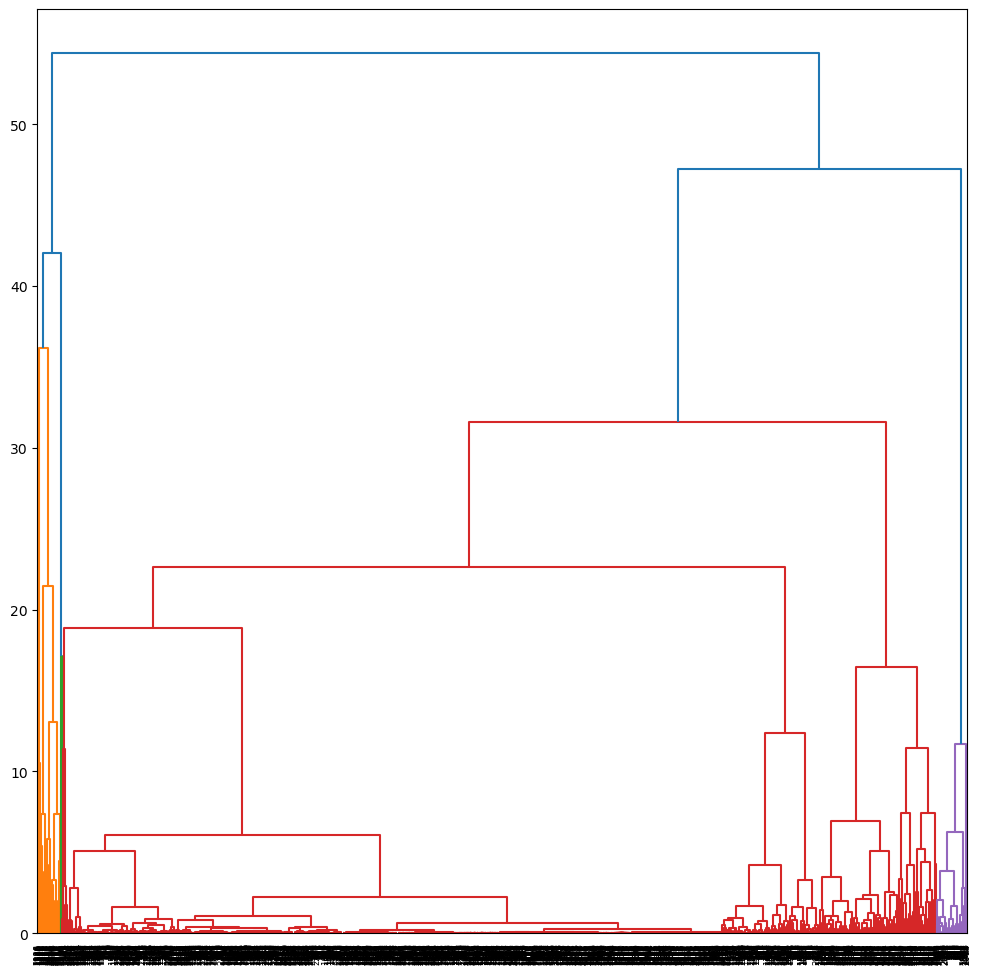

In [27]:
# grouping data based on Ward distance
standard_mergings_ward = linkage(y = pca_rescaled,
                                 method = 'ward',
                                 optimal_ordering = True)

# setting plot size
fig, ax = plt.subplots(figsize=(12, 12))

# developing a dendrogram
dendrogram(Z = standard_mergings_ward,
           leaf_rotation  = 90       ,
           leaf_font_size = 6        )

# rendering the plot
plt.show()

## Q4:

Based on the dendrogram, there are several tall vertical lines, but there are three that stand out as creating significant gaps, indicating potential cluster divisions. The longest of these lines appear to be around the y-axis values of 30, 40, and the tallest one reaching over 50.  So, there are 2 options for determined the number of clusters: either setting the threshold near the height of 40, which would yield around 3 clusters, or setting it above 50, which would yield 2 clusters. I will choose 3 because with more clusters, we can potentially gain more specific insights into subgroups within the data. Also, having more clusters provides more flexibility in analyzing the relationships between different data points. We can examine the structure within each cluster in more detail, which could reveal patterns that are not evident when the data is grouped into larger clusters.

In [28]:
# instantiating a k-Means object with clusters
users_k_pca = KMeans(n_clusters   = 3     ,
                         n_init       = 'auto',
                         random_state = 702   )

# fitting the object to the data
users_k_pca.fit(pca_rescaled)

# converting the clusters to a DataFrame
users_kmeans_pca = pd.DataFrame({'Cluster': users_k_pca.labels_})

# checking the results
print(users_kmeans_pca.iloc[: , 0].value_counts())

Cluster
1    2138
0     135
2      89
Name: count, dtype: int64


C:\Users\ihida\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=10.
  warnings.warn(


In [29]:
# storing cluster centers
centroids_pca = users_k_pca.cluster_centers_

# converting cluster centers into a DataFrame
centroids_pca_df = pd.DataFrame(centroids_pca).round(decimals = 2)

# renaming principal components
centroids_pca_df.columns = ['Social Spark',
                            'Emotion Catalyst',
                            'Controversial Charmer']

# checking results (clusters = rows, pc = columns)
centroids_pca_df

,Social Spark,Emotion Catalyst,Controversial Charmer
0,0.41,2.94,-1.09
1,-0.18,-0.13,0.10
2,3.77,-1.40,-0.78


## Q4:

A quick analysis on the clusters identified:

Cluster 0 has a high score on Emotion Catalyst (2.94) but a low score on Controversial Charmer (-1.09), and a relatively low but positive score on Social Spark (0.41). This could represent content that is highly likable, evoking a lot of positive emotions (likes) but not causing controversy or generating a lot of discussions and shares.

Cluster 1 has negative scores for most of its three components, though the scores are quite low, which suggests that posts in this cluster tend not to evoke strong reactions in any of the identified dimensions. These might be more neutral posts that neither generate much engagement nor stir up strong emotions.

Cluster 2 has a very high score for Social Spark (3.77), which implies a strong association with posts that generate a lot of interaction (comments, shares, and loves), but has negative scores for Emotion Catalyst (-1.40) and Controversial Charmer (-0.78), suggesting that while they generate discussion and sharing, they are less likely to be 'liked' or to elicit reactions of surprise or anger.

Based on these centroids, we can deduce that:

* Posts in Cluster 0 are likely the type that users enjoy and like but don’t feel compelled to comment on or share.
* Posts in Cluster 1 may not engage users strongly in any direction and may represent more informational or neutral content.
* Posts in Cluster 2 are the drivers of engagement in terms of sparking conversations and getting shared or loved, but they may not be the content that gets the most 'likes' or 'wow/angry' reactions.

In [30]:
# concatenating cluster memberships with principal components
clst_pca_df = pd.concat([users_kmeans_pca,
                         facebook_pca_3],
                         axis = 1)

# concatenating demographic information with pca-clusters
final_df = pd.concat([fb_df.loc[ : , ['status_type']],
                      clst_pca_df.round(decimals = 2)],
                      axis = 1)

# renaming columns
final_df.columns = ['Status Type', 'Cluster',
                    'Social Spark',
                    'Emotion Catalyst',
                    'Controversial Charmer',]

# checking the results
print(final_df.head(n = 5))

   Status Type  Cluster  Social Spark  Emotion Catalyst  Controversial Charmer
1          1.0      1.0         -0.47              0.13                   0.01
2          1.0      1.0         -0.47              0.13                   0.02
3          1.0      1.0          0.37              0.24                  -0.09
4          3.0      1.0         -0.02             -0.28                  -0.28
5          3.0      1.0         -0.40              0.15                   0.01


In [31]:
# renaming Status Type
status_names = {1 : 'photo',
                2 : 'text',
                3 : 'video'}

final_df['Status Type'].replace(status_names, inplace = True)

# renaming clusters
cluster_names = {0 : '1',
                 1 : '2',
                 2 : '3'}

final_df['Cluster'].replace(cluster_names, inplace = True)

# checking results
final_df.head(n = 5)

,Status Type,Cluster,Social Spark,Emotion Catalyst,Controversial Charmer
1,photo,2,-0.47,0.13,0.01
2,photo,2,-0.47,0.13,0.02
3,photo,2,0.37,0.24,-0.09
4,video,2,-0.02,-0.28,-0.28
5,video,2,-0.40,0.15,0.01


In [32]:
# dynamic string with value counts for each cluster (cluster 1)
print(f"""\
 -----------
| Cluster 1 |
 -----------

Proportion of Observations
--------------------------
{round(len(final_df.loc[ : , "Cluster"][final_df.loc[ : , "Cluster"] == '1']) /
       len(final_df), ndigits = 2)}


Centroids
---------
{centroids_pca_df.loc[ 0 , :].to_string(dtype = False, name = False)}


Status Type
-------
{final_df.loc[ : , "Status Type"][ final_df.loc[ : , 'Cluster' ] == '1']

         .value_counts(normalize = True)
         .round(decimals = 2)
         .sort_index().to_string(dtype = False, name = False)}
  
""")

 -----------
| Cluster 1 |
 -----------

Proportion of Observations
--------------------------
0.06


Centroids
---------
Social Spark             0.41
Emotion Catalyst         2.94
Controversial Charmer   -1.09


Status Type
-------
Status Type
photo    0.55
text     0.22
video    0.23
  



In [33]:
# dynamic string with value counts for each cluster (cluster 2)
print(f"""\
 -----------
| Cluster 2 |
 -----------

Proportion of Observations
--------------------------
{round(len(final_df.loc[ : , "Cluster"][final_df.loc[ : , "Cluster"] == '2']) /
       len(final_df), ndigits = 2)}


Centroids
---------
{centroids_pca_df.loc[ 0 , :].to_string(dtype = False, name = False)}


Status Type
-------
{final_df.loc[ : , "Status Type"][ final_df.loc[ : , 'Cluster' ] == '2']

         .value_counts(normalize = True)
         .round(decimals = 2)
         .sort_index().to_string(dtype = False, name = False)}
  
""")

 -----------
| Cluster 2 |
 -----------

Proportion of Observations
--------------------------
0.9


Centroids
---------
Social Spark             0.41
Emotion Catalyst         2.94
Controversial Charmer   -1.09


Status Type
-------
Status Type
photo    0.62
text     0.06
video    0.32
  



In [34]:
# dynamic string with value counts for each cluster (cluster 3)
print(f"""\
 -----------
| Cluster 3 |
 -----------

Proportion of Observations
--------------------------
{round(len(final_df.loc[ : , "Cluster"][final_df.loc[ : , "Cluster"] == '3']) /
       len(final_df), ndigits = 2)}


Centroids
---------
{centroids_pca_df.loc[ 0 , :].to_string(dtype = False, name = False)}


Status Type
-------
{final_df.loc[ : , "Status Type"][ final_df.loc[ : , 'Cluster' ] == '3']

         .value_counts(normalize = True)
         .round(decimals = 2)
         .sort_index().to_string(dtype = False, name = False)}
  
""")

 -----------
| Cluster 3 |
 -----------

Proportion of Observations
--------------------------
0.04


Centroids
---------
Social Spark             0.41
Emotion Catalyst         2.94
Controversial Charmer   -1.09


Status Type
-------
Status Type
photo    0.44
text     0.09
video    0.47
  



## Q5:

In [35]:
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report, confusion_matrix

In [36]:
# transforming photo = 1 and not photo = 0
fb_df['status_type'] = (fb_df['status_type'] == 1).astype(int)

In [37]:
# Model 1: Original x-features

# selecting x- and y-data
x_data = facebook_scaled
y_data = fb_df['status_type']

# training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x_data,
                                                    y_data,
                                                    test_size    = 0.25,
                                                    random_state = 702,
                                                    stratify     = y_data)

# instantiating a logistic regression model
model = sklearn.linear_model.LogisticRegression(solver       = 'lbfgs',
                                                C            = 1,
                                                random_state = 702)

# fitting the training data
model_fit = model.fit(x_train, y_train)

# predicting based on the testing set
model_pred = model_fit.predict(x_test)

# checking results
train_acc = model_fit.score(x_train, y_train)
test_acc  = model_fit.score(x_test , y_test )
roc_score = roc_auc_score  (y_true      = y_test,
                            y_score     = model_pred)

print(f"""
Train-Test Gap: {round(abs(train_acc - test_acc), ndigits = 3)}
Test AUC Score: {roc_score.round(decimals = 3)}
""")

# unpacking the confusion matrix
model_tn, \
model_fp, \
model_fn, \
model_tp = confusion_matrix(y_true = y_test, y_pred = model_pred).ravel()

# printing each result one-by-one
print(f"""
True Negatives : {model_tn}
False Positives: {model_fp}
False Negatives: {model_fn}
True Positives : {model_tp}
""")


Train-Test Gap: 0.014
Test AUC Score: 0.678


True Negatives : 91
False Positives: 139
False Negatives: 14
True Positives : 347



In [38]:
# Model 2: Retained principal components

# selecting x- and y-data
x_data = facebook_pca_3
y_data = fb_df['status_type']

# training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x_data,
                                                    y_data,
                                                    test_size    = 0.25,
                                                    random_state = 702,
                                                    stratify     = y_data)

# instantiating a logistic regression model
model = sklearn.linear_model.LogisticRegression(solver       = 'lbfgs',
                                                C            = 1,
                                                random_state = 702)

# fitting the training data
model_fit = model.fit(x_train, y_train)

# predicting based on the testing set
model_pred = model_fit.predict(x_test)

# checking results
train_acc = model_fit.score(x_train, y_train)
test_acc  = model_fit.score(x_test , y_test )
roc_score = roc_auc_score  (y_true      = y_test,
                            y_score     = model_pred)

print(f"""
Train-Test Gap: {round(abs(train_acc - test_acc), ndigits = 3)}
Test AUC Score: {roc_score.round(decimals = 3)}
""")

# unpacking the confusion matrix
model_tn, \
model_fp, \
model_fn, \
model_tp = confusion_matrix(y_true = y_test, y_pred = model_pred).ravel()

# printing each result one-by-one
print(f"""
True Negatives : {model_tn}
False Positives: {model_fp}
False Negatives: {model_fn}
True Positives : {model_tp}
""")


Train-Test Gap: 0.008
Test AUC Score: 0.667


True Negatives : 85
False Positives: 145
False Negatives: 13
True Positives : 348



In [39]:
# Model 3: Retained clusters

# factorizing cluster results 
cluster_df = pd.get_dummies(data       = users_kmeans_pca ['Cluster'],
                            drop_first = True).astype(dtype = int)

# checking results
cluster_df.value_counts(normalize = False).sort_index(ascending = False)

# selecting x- and y-data
x_data = cluster_df
y_data = fb_df['status_type']

# training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x_data,
                                                    y_data,
                                                    test_size    = 0.25,
                                                    random_state = 702,
                                                    stratify     = y_data)

# instantiating a logistic regression model
model = sklearn.linear_model.LogisticRegression(solver       = 'lbfgs',
                                                C            = 1,
                                                random_state = 702)

# fitting the training data
model_fit = model.fit(x_train, y_train)

# predicting based on the testing set
model_pred = model_fit.predict(x_test)

# checking results
train_acc = model_fit.score(x_train, y_train)
test_acc  = model_fit.score(x_test , y_test )
roc_score = roc_auc_score  (y_true      = y_test,
                            y_score     = model_pred)

print(f"""
Train-Test Gap: {round(abs(train_acc - test_acc), ndigits = 3)}
Test AUC Score: {roc_score.round(decimals = 3)}
""")

# unpacking the confusion matrix
model_tn, \
model_fp, \
model_fn, \
model_tp = confusion_matrix(y_true = y_test, y_pred = model_pred).ravel()

# printing each result one-by-one
print(f"""
True Negatives : {model_tn}
False Positives: {model_fp}
False Negatives: {model_fn}
True Positives : {model_tp}
""")


Train-Test Gap: 0.019
Test AUC Score: 0.527


True Negatives : 15
False Positives: 215
False Negatives: 4
True Positives : 357



## Q6:

Analysis of the 3 logistic regression models:

Model 1 has the highest Test AUC Score, indicating it has the best ability to discriminate between the positive and negative classes. Its Train-Test Gap is also small, suggesting good generalization from the training data to the test data.

Model 2 has a slightly lower AUC Score than Model 1, but the smallest Train-Test Gap, which indicates the best generalization. However, the higher number of False Positives compared to Model 1 could be a concern depending on the cost/impact of false alarms in the application.

Model 3 has the lowest AUC Score, suggesting poor performance in distinguishing between the classes. Despite having the highest number of True Positives, its ability to correctly identify the negative class is very weak (only 15 True Negatives), which is typically undesirable. It also has the largest Train-Test Gap, indicating potential overfitting.

Given these results, Model 1 appears to be the best model among the three due to its balance of a high AUC Score, a low number of False Negatives, and a reasonable number of False Positives. It also has a good balance between sensitivity (ability to detect true positives) and specificity (ability to detect true negatives). The choice, however, might also depend on the specific costs associated with False Positives and False Negatives in the context where the model will be applied. If the cost of False Positives is high, Model 1 still seems to be a better choice than Model 2 due to its higher AUC Score, despite having a few more False Positives. Model 3 is generally not preferred because of its low specificity and potential overfitting.